In [1]:
# Imports 
import gym
import numpy as np
from gym.spaces import Box
import gfootball.env as football_env
from gfootball.env import create_environment as _create_env
from gym.wrappers import FrameStack
import matplotlib.pyplot as plt
import torch


Get all the scenerios available

In [2]:
from gfootball.env.scenario_builder import all_scenarios
print(all_scenarios())

['11_vs_11_competition', '11_vs_11_easy_stochastic', '11_vs_11_hard_stochastic', '11_vs_11_kaggle', '11_vs_11_stochastic', '1_vs_1_easy', '5_vs_5', 'academy_3_vs_1_with_keeper', 'academy_corner', 'academy_counterattack_easy', 'academy_counterattack_hard', 'academy_empty_goal', 'academy_empty_goal_close', 'academy_pass_and_shoot_with_keeper', 'academy_run_pass_and_shoot_with_keeper', 'academy_run_to_score', 'academy_run_to_score_with_keeper', 'academy_single_goal_versus_lazy', 'test_example_multiagent', 'tests']


We will use the stacked extracted representation of the game as it gave the best results in the original paper. (We will have to transpose the observation before feeding it to pytorch) 

In [3]:
env = football_env.create_environment(
    env_name='11_vs_11_stochastic',
    representation='extracted',
    stacked=True,
    number_of_left_players_agent_controls=1,
    render=False
)
print(env.observation_space.shape)  # -> (72, 96, 16)
print(env.action_space)  # -> Discrete(19)
print(env.reward_range)

(72, 96, 16)
Discrete(19)
(-inf, inf)


Lets display what our observation looks like

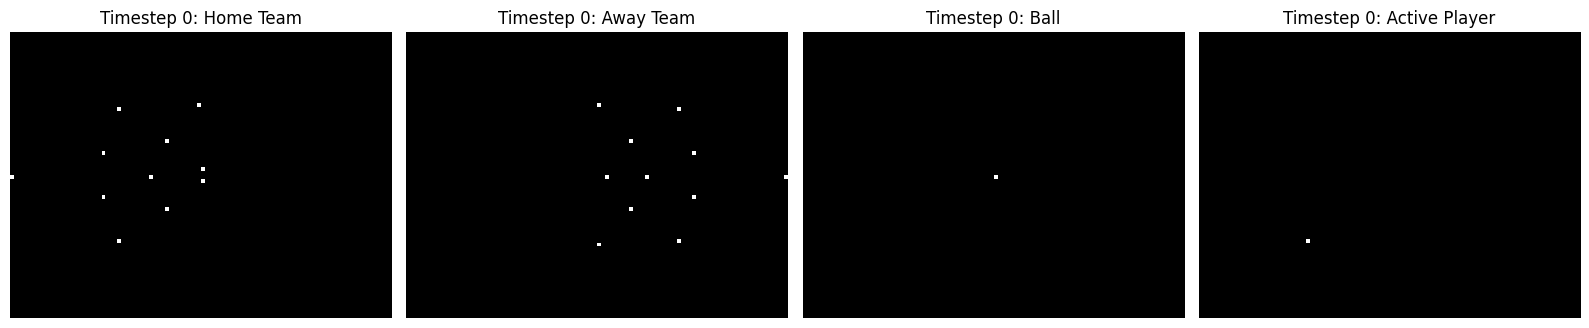

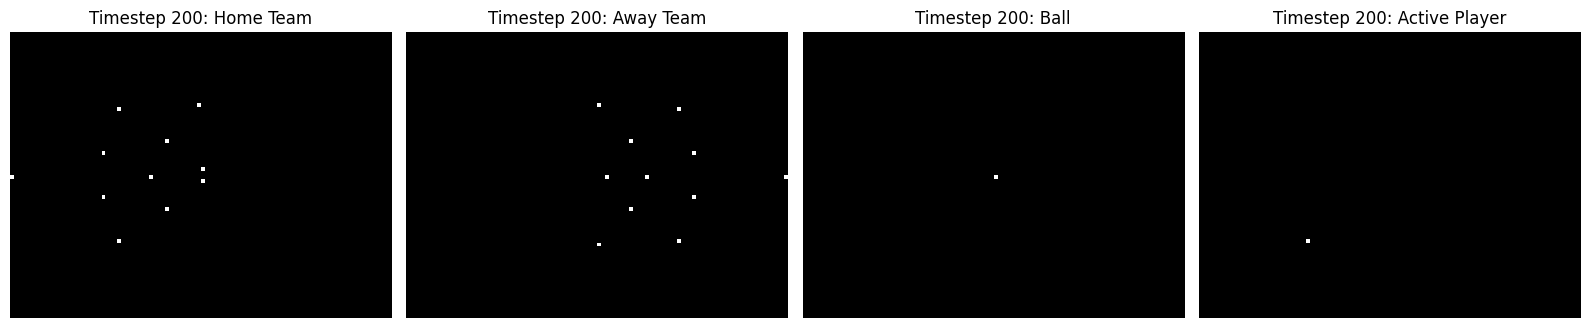

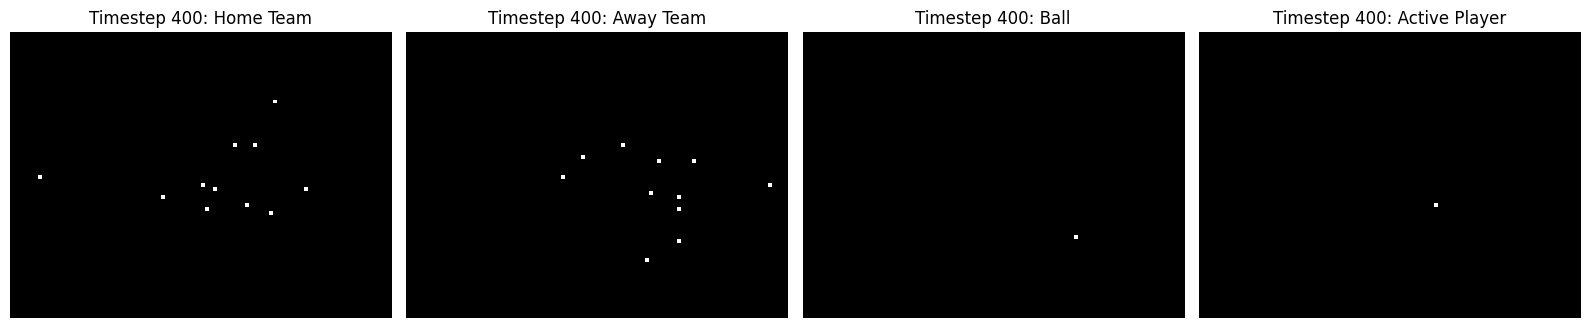

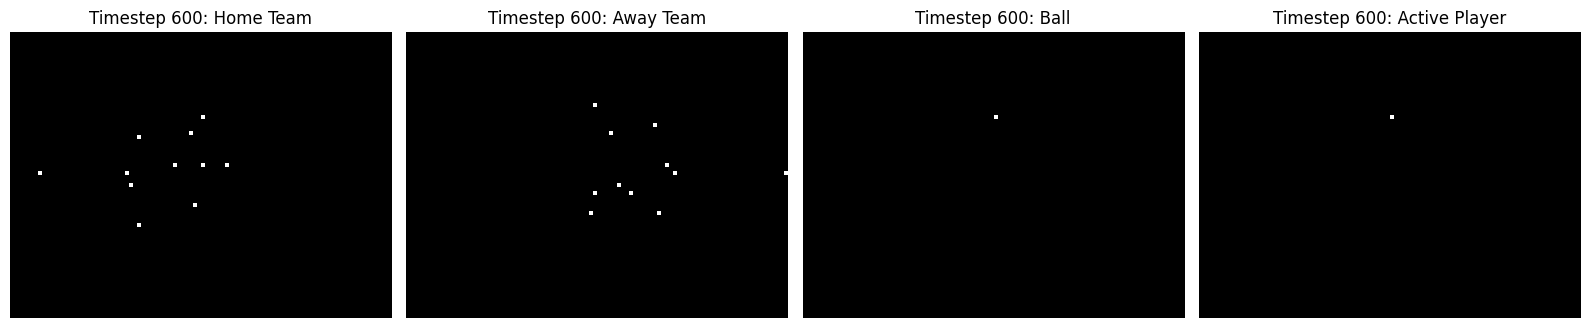

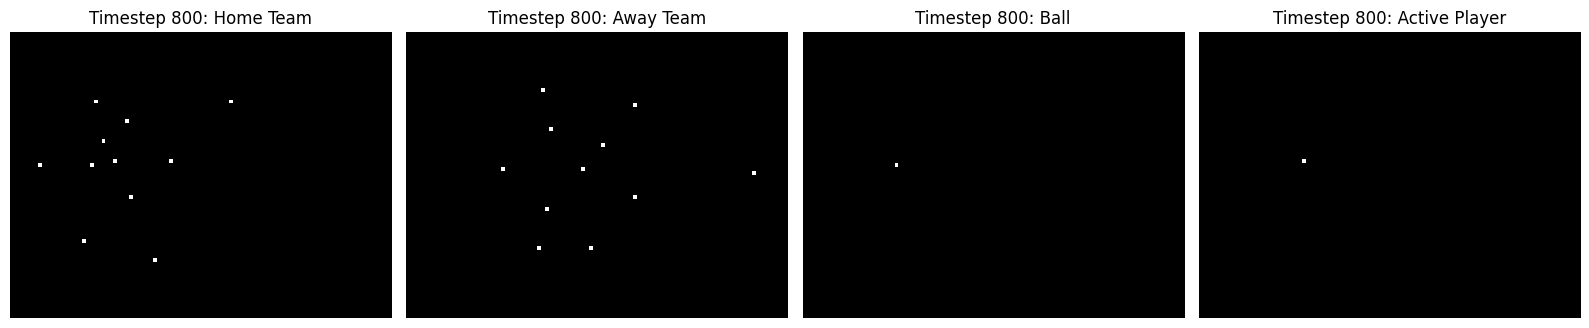

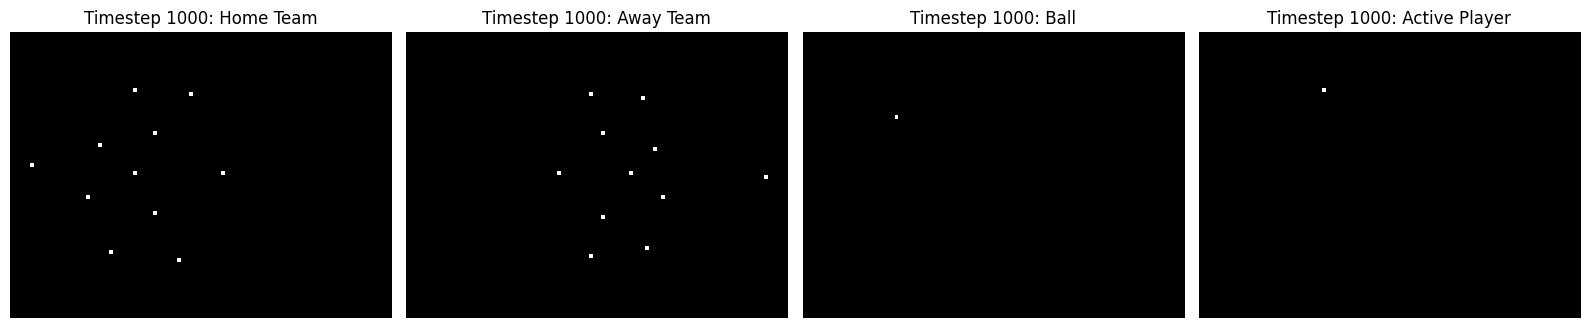

In [4]:
# Reset and collect the first frame (t=0)
frames = []
obs = env.reset()  # obs.shape == (72, 96, 16)
frames.append(obs)

# 3) Step and collect every 10th stacked frame
for step in range(1000):
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    

    if step % 200 == 0:
        # reshape from (72,96,16) → (H=72, W=96, stack=4, channels=4,)
        obs4 = obs.reshape(72, 96, 4, 4)

        # iterate over the 4 stacked frames
        for k in range(obs4.shape[2]):
            # obs4[k] has shape (72,96,4): (H, W, channels)

            frame = obs4[:, :, k, :]  # shape: (72, 96, 4)
            frames.append(frame)
            break


    if done:
        break
# 4) Visualize
plane_names = ['Home Team', 'Away Team', 'Ball', 'Active Player']

for t, frame in enumerate(frames):
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    for i, ax in enumerate(axes):
        ax.imshow(frame[:, :, i], cmap='gray', vmin=0, vmax=1)
        ax.set_title(f'Timestep {t*200}: {plane_names[i]}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [5]:
# TODO 1: Reward Engineering
# TODO 2: Action Blocking
# TODO 3: Create your CNN-PPO 
# TODO 4: Train you agent on the easiest academy scenerio
# TODO 5: Figure out if you can visualize your agent with pixels after training it on the extracted representation

dPPO architecture used in the paper 

input: (72, 96, 16) (they have used tensorflow, we will transpose this to (16, 72, 96) to use pytorch) <br>
x4: 

# Environment initialization

In [6]:
# Basic imports
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import time

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

# gfootball import
import gfootball.env as football_env

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Optional: Environment Wrappers (Consider simplifying observations or actions)
# from gfootball.env import wrappers
# Example: env = wrappers.SimpleObservationWrapper(env)
# Example: env = wrappers.FrameStack(env, 4) # If using frame stacking

Using device: cpu


In [7]:
def create_gfootball_env(scenario_name, representation='extracted', stacked=True):
    """Helper function to create and wrap the environment."""
    env = football_env.create_environment(
        env_name=scenario_name,
        representation=representation, # 'pixels' or 'SMM' are good for CNNs
        stacked=stacked,             # Stacking frames can help capture dynamics
        rewards='scoring,checkpoints', # Example reward shaping
        logdir='/tmp/football',       # Optional logging
        write_goal_dumps=False,
        write_full_episode_dumps=False,
        render=False                 # Set to True for visualization if needed
    )
    # Add any necessary wrappers here (e.g., frame skipping, resizing, normalization)
    # env = wrappers.FrameSkip(env, skip=4)
    # env = YourCustomObservationWrapper(env) # e.g., resize, grayscale, normalize

    env = football_env.wrappers.FrameStack(env, 4)  # Stack 4 frames for temporal context
    
    return env

# --- Curriculum Scenarios ---
# Define the scenarios for curriculum learning
# Start with easier ones and progress to harder ones
curriculum_scenarios = [
    'academy_empty_goal_close',
    'academy_run_to_score_with_keeper',
    'academy_pass_and_shoot_with_keeper',
    'academy_3_vs_1_with_keeper',
    # '1_vs_1_easy', # Uncomment or add more scenarios
    # '11_vs_11_easy_stochastic',
    # '11_vs_11_stochastic',
]

# --- Initialize with the first scenario ---
current_scenario_index = 0
env = create_gfootball_env(curriculum_scenarios[current_scenario_index])

# Get observation and action space dimensions
# Note: Observation shape depends heavily on representation and wrappers
obs_space_shape = env.observation_space.shape
# If using 'pixels' and FrameStack, shape might be (stack_size, height, width, channels)
# Or after permutation for PyTorch (stack_size * channels, height, width)
# Adjust based on your chosen representation and wrappers
# For this example, assume preprocessed shape (e.g., (4, 72, 96) after stacking and processing)
num_actions = env.action_space.n

print(f"Observation space shape: {obs_space_shape}")
print(f"Number of actions: {num_actions}")

Observation space shape: (72, 96, 64)
Number of actions: 19


# Model Definition

In [8]:
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    """Initialize layer weights."""
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

class ActorCritic(nn.Module):
    def __init__(self, num_actions, input_channels=64): # input_channels depends on frame stacking
        super(ActorCritic, self).__init__()

        # CNN base for feature extraction
        # Input shape depends on preprocessing (e.g., (input_channels, 72, 96))
        self.network = nn.Sequential(
            layer_init(nn.Conv2d(input_channels, 32, kernel_size=8, stride=4)),
            nn.ReLU(),
            layer_init(nn.Conv2d(32, 64, kernel_size=4, stride=2)),
            nn.ReLU(),
            layer_init(nn.Conv2d(64, 64, kernel_size=3, stride=1)),
            nn.ReLU(),
            nn.Flatten(),
            # The input size to the linear layer depends on the output shape of the last conv layer
            # Calculate this based on input dimensions (72, 96) and conv operations
            # Example calculation for (72, 96) -> (16, 22) -> (7, 10) -> (5, 8) -> Flattened = 64*5*8 = 2560
            # You MUST calculate this correctly based on your actual input dimensions and CNN layers
            layer_init(nn.Linear(2048, 512)), # Adjust 64 * 7 * 9 based on actual calculation
            nn.ReLU()
        )

        # Actor head (outputs action probabilities)
        self.actor = layer_init(nn.Linear(512, num_actions), std=0.01)

        # Critic head (outputs state value)
        self.critic = layer_init(nn.Linear(512, 1), std=1)

    def get_value(self, x):
        # Preprocess x if not already done (e.g., normalize, permute dims)
        # x = x / 255.0 # Example normalization
        # x = x.permute(0, 3, 1, 2) # Example permutation if input is (N, H, W, C)
        return self.critic(self.network(x))

    def get_action_and_value(self, x, action=None):
        # Preprocess x if not already done
        # x = x / 255.0 # Example normalization
        # x = x.permute(0, 3, 1, 2) # Example permutation if input is (N, H, W, C)
        hidden = self.network(x)
        logits = self.actor(hidden)
        probs = Categorical(logits=logits)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action), probs.entropy(), self.critic(hidden)

stacked = True
# Instantiate the model
agent = ActorCritic(num_actions, input_channels=obs_space_shape[0] if stacked else 1).to(device) # Adjust input_channels
optimizer = optim.Adam(agent.parameters(), lr=2.5e-4, eps=1e-5)

# PPO Agent

In [9]:
# --- PPO Hyperparameters ---
NUM_STEPS = 128           # Steps per environment per policy rollout collection
NUM_ENVS = 4              # Number of parallel environments (if using VecEnv) - requires adjustments
TOTAL_TIMESTEPS = 100_000
LEARNING_RATE = 2.5e-4
GAMMA = 0.99              # Discount factor
GAE_LAMBDA = 0.95         # Lambda for Generalized Advantage Estimation
NUM_MINIBATCHES = 4       # Number of minibatches for PPO updates
UPDATE_EPOCHS = 4         # Number of epochs for PPO updates per rollout
CLIP_COEF = 0.1           # PPO clipping coefficient
ENT_COEF = 0.01           # Entropy coefficient
VF_COEF = 0.5             # Value function coefficient
MAX_GRAD_NORM = 0.5       # Gradient clipping threshold
TARGET_KL = None          # Optional: Target KL divergence for early stopping

# --- Curriculum Learning ---
CURRICULUM_THRESHOLD = 0.8 # Example: Switch scenario if avg reward > threshold * max_possible_reward
                           # Needs tuning based on scenario difficulty and reward scale.
                           # Alternatively, switch after a fixed number of steps/episodes.

# --- Tracking ---
global_step = 0
start_time = time.time()
# Store metrics per scenario (Keep as before)
scenario_rewards = {scenario: [] for scenario in curriculum_scenarios}
scenario_losses = {scenario: {'policy_loss': [], 'value_loss': [], 'entropy_loss': []} for scenario in curriculum_scenarios}
scenario_episode_lengths = {scenario: [] for scenario in curriculum_scenarios}

# Add accumulators for the current episode's reward and length
current_ep_reward = 0.0
current_ep_length = 0


In [10]:
# Simple buffer storage (adjust for parallel environments if used)
obs_buffer = torch.zeros((NUM_STEPS,) + obs_space_shape).to(device)
actions_buffer = torch.zeros((NUM_STEPS,)).to(device)
logprobs_buffer = torch.zeros((NUM_STEPS,)).to(device)
rewards_buffer = torch.zeros((NUM_STEPS,)).to(device)
dones_buffer = torch.zeros((NUM_STEPS,)).to(device)
values_buffer = torch.zeros((NUM_STEPS,)).to(device)

In [11]:
from tqdm import trange

# Preprocess initial observation
# obs = preprocess_obs(env.reset()) # Your preprocessing function/wrapper
# --- You need to implement preprocess_obs ---
# Example placeholder:
def preprocess_obs(obs_list):
    # Assuming obs_list is a list of observations (if multiple agents)
    # For single agent, obs_list[0] is the observation
    # Apply: resize, grayscale, normalize, stack (if not done by wrapper), permute HWC -> CHW
    # Return a torch tensor on the correct device
    processed = torch.tensor(np.array(obs_list), dtype=torch.float32).to(device) # Placeholder
    # Example for pixels: (H, W, C*stack) -> (C*stack, H, W)
    
    '''
    if len(processed.shape) == 3 and processed.shape[-1] > 3: # HWC format assumed
       processed = processed.permute(2, 1, 0)
    elif len(processed.shape) == 4 and processed.shape[-1] > 3: # N H W C format (if env returns batch dim)
        processed = processed.permute(0, 3, 2, 1)
    '''
    
    # Add normalization etc.
    # processed = processed / 255.0
    # Ensure it has batch dimension for the network
    if len(processed.shape) == 3:
      processed = processed.unsqueeze(0) # Add batch dim: (C, H, W) -> (1, C, H, W)

    return processed


# Get initial observation - assuming single env for simplicity here
# reset() returns tuple: (obs_list, reward, done, info) or similar

initial_obs_list = env.reset()
next_obs = preprocess_obs(initial_obs_list) # Process initial observation

next_done = torch.zeros(1).to(device) # Assuming single env

# Track episode rewards and lengths for the current scenario
current_episode_rewards = deque(maxlen=50) # Track last 50 episode rewards for curriculum check
current_episode_lengths = deque(maxlen=50)


num_updates = TOTAL_TIMESTEPS // (NUM_STEPS * NUM_ENVS) # Adjust if not using NUM_ENVS=1
# Initialize buffers for PPO training
obs_buffer = torch.zeros((NUM_STEPS,) + obs_space_shape).to(device)
actions_buffer = torch.zeros((NUM_STEPS,)).to(device)
logprobs_buffer = torch.zeros((NUM_STEPS,)).to(device)
rewards_buffer = torch.zeros((NUM_STEPS,)).to(device)
dones_buffer = torch.zeros((NUM_STEPS,)).to(device)
values_buffer = torch.zeros((NUM_STEPS,)).to(device)

# Track global step count
global_step = 0

for update in trange(1, num_updates + 1):
    # Adjust learning rate if needed (linear decay is common)
    # frac = 1.0 - (update - 1.0) / num_updates
    # lrnow = frac * LEARNING_RATE
    # optimizer.param_groups[0]["lr"] = lrnow

    # === Rollout Phase ===
    agent.eval() # Set agent to evaluation mode for rollout
    for step in range(0, NUM_STEPS):
        global_step += 1 # Increment global step count
        current_ep_length += 1 # Increment episode step counter

        obs_buffer[step] = next_obs.squeeze(0) # Remove batch dim if single env
        dones_buffer[step] = next_done.squeeze(0)

        # Get action and value from the agent
        with torch.no_grad():
            action, logprob, _, value = agent.get_action_and_value(next_obs)
            values_buffer[step] = value.flatten()
        actions_buffer[step] = action
        logprobs_buffer[step] = logprob

        # Execute action in the environment
        # step() returns tuple: (obs_list, reward, done, info)
        # IMPORTANT: Ensure obs_list, reward, done are handled correctly for single/multi-env
        obs_list, reward, terminated, info = env.step(action.cpu().numpy()[0]) # Using new Gym API return values
        done = terminated # Combine termination conditions
        # Store reward
        rewards_buffer[step] = torch.tensor(reward).to(device).view(-1)
        # Accumulate reward for the current episode
        current_ep_reward += reward

        # Prepare next observation and done state
        next_obs = preprocess_obs(obs_list)
        # Use done instead of just terminated
        next_done = torch.tensor([done]).to(device).float().view(-1)

        # --- Check for Episode End ---
        # If the episode ended (done is True)
        if done:
            current_scenario = curriculum_scenarios[current_scenario_index]
            print(f"Scenario: {current_scenario}, global_step={global_step}, ep_reward={current_ep_reward:.2f}, ep_length={current_ep_length}")

            # Store metrics
            current_episode_rewards.append(current_ep_reward)
            current_episode_lengths.append(current_ep_length)
            scenario_rewards[current_scenario].append(current_ep_reward)
            scenario_episode_lengths[current_scenario].append(current_ep_length)

            # Reset episode accumulators
            current_ep_reward = 0.0
            current_ep_length = 0
            # The environment resets automatically with wrappers or needs manual reset if not using wrappers like AutoResetWrapper
            # If using vectorized envs, they often handle resets automatically.
            # If using a single env without AutoResetWrapper, you might need:
            initial_obs_list = env.reset()
            next_obs = preprocess_obs(initial_obs_list)
            next_done = torch.zeros(1).to(device)


    # === Advantage Calculation (GAE) ===
    agent.eval() # Ensure agent is in eval mode
    with torch.no_grad():
        next_value = agent.get_value(next_obs).reshape(1, -1)
        # Ensure next_done corresponds to the state *after* the last step
        # If the last step ended the episode, next_done should be 1, otherwise 0.
        last_step_done = next_done
        advantages = torch.zeros_like(rewards_buffer).to(device)
        lastgaelam = 0
        for t in reversed(range(NUM_STEPS)):
            if t == NUM_STEPS - 1:
                # Use the 'done' status after the last step was taken
                nextnonterminal = 1.0 - last_step_done.float()
                nextvalues = next_value
            else:
                nextnonterminal = 1.0 - dones_buffer[t + 1]
                nextvalues = values_buffer[t + 1]
            delta = rewards_buffer[t] + GAMMA * nextvalues * nextnonterminal - values_buffer[t]
            advantages[t] = lastgaelam = delta + GAMMA * GAE_LAMBDA * nextnonterminal * lastgaelam
        returns = advantages + values_buffer # GAE returns

    # Flatten batch for training
    b_obs = obs_buffer.reshape((-1,) + obs_space_shape)
    b_logprobs = logprobs_buffer.reshape(-1)
    b_actions = actions_buffer.reshape(-1)
    b_advantages = advantages.reshape(-1)
    b_returns = returns.reshape(-1)
    b_values = values_buffer.reshape(-1)

    # === Update Phase ===
    agent.train() # Set agent to training mode
    clipfracs = []
    batch_size = b_obs.shape[0] # Should be NUM_STEPS * NUM_ENVS
    minibatch_size = batch_size // NUM_MINIBATCHES

    for epoch in range(UPDATE_EPOCHS):
        b_inds = np.random.permutation(batch_size) # Shuffle indices
        for start in range(0, batch_size, minibatch_size):
            end = start + minibatch_size
            mb_inds = b_inds[start:end]

            # Get data for minibatch
            mb_obs = b_obs[mb_inds]
            mb_actions = b_actions[mb_inds]
            mb_logprobs = b_logprobs[mb_inds]
            mb_advantages = b_advantages[mb_inds]
            mb_returns = b_returns[mb_inds]

            # Get new logprobs, entropy, and values from agent
            _, newlogprob, entropy, newvalue = agent.get_action_and_value(mb_obs, mb_actions.long()) # Ensure actions are long ints
            logratio = newlogprob - mb_logprobs
            ratio = logratio.exp()

            with torch.no_grad():
                 # calculate approx_kl http://joschu.net/blog/kl-approx.html
                approx_kl = ((ratio - 1) - logratio).mean()
                clipfracs += [((ratio - 1.0).abs() > CLIP_COEF).float().mean().item()]

            # Normalize advantages (optional but recommended)
            mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

            # Policy loss (PPO-Clip objective)
            pg_loss1 = -mb_advantages * ratio
            pg_loss2 = -mb_advantages * torch.clamp(ratio, 1 - CLIP_COEF, 1 + CLIP_COEF)
            pg_loss = torch.max(pg_loss1, pg_loss2).mean()

            # Value loss
            newvalue = newvalue.view(-1)
            # Use clipped value loss if desired
            v_loss = F.mse_loss(newvalue, mb_returns) # Simple MSE loss

            # Entropy loss
            entropy_loss = entropy.mean()

            # Total loss
            loss = pg_loss - ENT_COEF * entropy_loss + VF_COEF * v_loss

            # Optimization step
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(agent.parameters(), MAX_GRAD_NORM) # Clip gradients
            optimizer.step()

        # Optional: KL divergence early stopping
        if TARGET_KL is not None and approx_kl > TARGET_KL:
            print(f"Early stopping at epoch {epoch} due to reaching max KL divergence.")
            break

    # === Record Losses (average over last epoch) ===
    current_scenario = curriculum_scenarios[current_scenario_index]
    scenario_losses[current_scenario]['policy_loss'].append(pg_loss.item())
    scenario_losses[current_scenario]['value_loss'].append(v_loss.item())
    scenario_losses[current_scenario]['entropy_loss'].append(entropy_loss.item())


    # === Curriculum Learning Check ===
    # This part should now work correctly as current_episode_rewards is populated properly
    if len(current_episode_rewards) >= 10: # Check if enough episodes completed in current scenario
        avg_reward = np.mean(current_episode_rewards)
        # Define a success condition (e.g., average reward exceeds a threshold)
        updates_per_scenario = 500 # Example
        # Or use a performance threshold:
        # reward_threshold = 0.5 # Example: 0.5 reward in simple scenarios
        # if avg_reward >= reward_threshold and current_scenario_index < len(curriculum_scenarios) - 1:
        if update % updates_per_scenario == 0 and current_scenario_index < len(curriculum_scenarios) - 1: # Using fixed updates for simplicity
              print(f"Completed {updates_per_scenario} updates on {curriculum_scenarios[current_scenario_index]}. Average reward (last 50 eps): {avg_reward:.2f}")
              current_scenario_index += 1
              print(f"Switching to scenario: {curriculum_scenarios[current_scenario_index]}")
              env.close() # Close the old environment
              env = create_gfootball_env(curriculum_scenarios[current_scenario_index])
              # Reset observation and tracking for the new scenario
              initial_obs_list, _, _, _ = env.reset()
              next_obs = preprocess_obs(initial_obs_list)
              next_done = torch.zeros(1).to(device)
              current_episode_rewards.clear()
              current_episode_lengths.clear()
              # Reset episode accumulators for the new env
              current_ep_reward = 0.0
              current_ep_length = 0


env.close()
print("Training finished.")

  0%|          | 0/195 [00:00<?, ?it/s]

Scenario: academy_empty_goal_close, global_step=16, ep_reward=0.90, ep_length=16
Scenario: academy_empty_goal_close, global_step=103, ep_reward=0.20, ep_length=87


  1%|          | 1/195 [00:03<10:08,  3.14s/it]

Scenario: academy_empty_goal_close, global_step=181, ep_reward=0.90, ep_length=78
Scenario: academy_empty_goal_close, global_step=191, ep_reward=2.00, ep_length=10


  2%|▏         | 3/195 [00:08<08:38,  2.70s/it]

Scenario: academy_empty_goal_close, global_step=410, ep_reward=1.00, ep_length=219


  2%|▏         | 4/195 [00:10<08:21,  2.62s/it]

Scenario: academy_empty_goal_close, global_step=582, ep_reward=0.90, ep_length=172


  3%|▎         | 5/195 [00:13<07:54,  2.50s/it]

Scenario: academy_empty_goal_close, global_step=682, ep_reward=0.00, ep_length=100
Scenario: academy_empty_goal_close, global_step=758, ep_reward=0.90, ep_length=76


  3%|▎         | 6/195 [00:15<07:46,  2.47s/it]

Scenario: academy_empty_goal_close, global_step=774, ep_reward=2.00, ep_length=16
Scenario: academy_empty_goal_close, global_step=891, ep_reward=0.90, ep_length=117


  4%|▎         | 7/195 [00:17<07:39,  2.44s/it]

Scenario: academy_empty_goal_close, global_step=962, ep_reward=0.20, ep_length=71


  5%|▍         | 9/195 [00:22<07:37,  2.46s/it]

Scenario: academy_empty_goal_close, global_step=1232, ep_reward=0.90, ep_length=270


  5%|▌         | 10/195 [00:25<07:36,  2.47s/it]

Scenario: academy_empty_goal_close, global_step=1302, ep_reward=0.20, ep_length=70


  6%|▌         | 11/195 [00:27<07:39,  2.50s/it]

Scenario: academy_empty_goal_close, global_step=1453, ep_reward=2.00, ep_length=151


  7%|▋         | 14/195 [00:35<07:48,  2.59s/it]

Scenario: academy_empty_goal_close, global_step=1854, ep_reward=0.90, ep_length=401


  8%|▊         | 16/195 [00:40<07:37,  2.56s/it]

Scenario: academy_empty_goal_close, global_step=2063, ep_reward=0.90, ep_length=209


  9%|▊         | 17/195 [00:43<07:24,  2.50s/it]

Scenario: academy_empty_goal_close, global_step=2212, ep_reward=0.20, ep_length=149


  9%|▉         | 18/195 [00:45<07:08,  2.42s/it]

Scenario: academy_empty_goal_close, global_step=2390, ep_reward=0.90, ep_length=178


 10%|▉         | 19/195 [00:47<06:56,  2.37s/it]

Scenario: academy_empty_goal_close, global_step=2477, ep_reward=0.90, ep_length=87


 10%|█         | 20/195 [00:49<06:43,  2.31s/it]

Scenario: academy_empty_goal_close, global_step=2674, ep_reward=1.00, ep_length=197


 11%|█         | 21/195 [00:52<06:34,  2.27s/it]

Scenario: academy_empty_goal_close, global_step=2689, ep_reward=2.00, ep_length=15
Scenario: academy_empty_goal_close, global_step=2771, ep_reward=1.00, ep_length=82


 12%|█▏        | 24/195 [01:00<07:37,  2.68s/it]

Scenario: academy_empty_goal_close, global_step=3079, ep_reward=0.90, ep_length=308
Scenario: academy_empty_goal_close, global_step=3144, ep_reward=0.90, ep_length=65


 13%|█▎        | 25/195 [01:03<07:32,  2.66s/it]

Scenario: academy_empty_goal_close, global_step=3204, ep_reward=0.90, ep_length=60


 13%|█▎        | 26/195 [01:05<07:34,  2.69s/it]

Scenario: academy_empty_goal_close, global_step=3427, ep_reward=0.90, ep_length=223


 14%|█▍        | 27/195 [01:08<07:15,  2.59s/it]

Scenario: academy_empty_goal_close, global_step=3522, ep_reward=0.90, ep_length=95


 14%|█▍        | 28/195 [01:10<06:58,  2.51s/it]

Scenario: academy_empty_goal_close, global_step=3590, ep_reward=0.90, ep_length=68
Scenario: academy_empty_goal_close, global_step=3685, ep_reward=0.90, ep_length=95


 15%|█▍        | 29/195 [01:12<06:33,  2.37s/it]

Scenario: academy_empty_goal_close, global_step=3797, ep_reward=0.90, ep_length=112


 16%|█▋        | 32/195 [01:18<05:51,  2.16s/it]

Scenario: academy_empty_goal_close, global_step=4198, ep_reward=0.90, ep_length=401


 17%|█▋        | 33/195 [01:20<05:42,  2.12s/it]

Scenario: academy_empty_goal_close, global_step=4277, ep_reward=1.00, ep_length=79


 17%|█▋        | 34/195 [01:22<05:35,  2.08s/it]

Scenario: academy_empty_goal_close, global_step=4361, ep_reward=0.90, ep_length=84
Scenario: academy_empty_goal_close, global_step=4454, ep_reward=-0.80, ep_length=93
Scenario: academy_empty_goal_close, global_step=4467, ep_reward=2.00, ep_length=13


 18%|█▊        | 35/195 [01:24<05:33,  2.09s/it]

Scenario: academy_empty_goal_close, global_step=4563, ep_reward=0.90, ep_length=96


 18%|█▊        | 36/195 [01:27<05:32,  2.09s/it]

Scenario: academy_empty_goal_close, global_step=4651, ep_reward=0.90, ep_length=88


 19%|█▉        | 37/195 [01:29<05:41,  2.16s/it]

Scenario: academy_empty_goal_close, global_step=4744, ep_reward=0.90, ep_length=93


 21%|██        | 40/195 [01:36<05:44,  2.22s/it]

Scenario: academy_empty_goal_close, global_step=5145, ep_reward=0.90, ep_length=401


 21%|██        | 41/195 [01:38<05:43,  2.23s/it]

Scenario: academy_empty_goal_close, global_step=5341, ep_reward=0.90, ep_length=196


 22%|██▏       | 42/195 [01:40<05:36,  2.20s/it]

Scenario: academy_empty_goal_close, global_step=5471, ep_reward=0.90, ep_length=130


 22%|██▏       | 43/195 [01:42<05:29,  2.17s/it]

Scenario: academy_empty_goal_close, global_step=5561, ep_reward=0.20, ep_length=90
Scenario: academy_empty_goal_close, global_step=5621, ep_reward=0.90, ep_length=60


 23%|██▎       | 44/195 [01:44<05:31,  2.20s/it]

Scenario: academy_empty_goal_close, global_step=5724, ep_reward=0.90, ep_length=103


 23%|██▎       | 45/195 [01:46<05:22,  2.15s/it]

Scenario: academy_empty_goal_close, global_step=5833, ep_reward=-0.10, ep_length=109


 24%|██▎       | 46/195 [01:48<05:12,  2.10s/it]

Scenario: academy_empty_goal_close, global_step=6010, ep_reward=0.90, ep_length=177


 24%|██▍       | 47/195 [01:50<05:07,  2.07s/it]

Scenario: academy_empty_goal_close, global_step=6085, ep_reward=0.90, ep_length=75


 26%|██▌       | 50/195 [01:57<04:59,  2.06s/it]

Scenario: academy_empty_goal_close, global_step=6486, ep_reward=0.90, ep_length=401


 27%|██▋       | 53/195 [02:03<05:04,  2.15s/it]

Scenario: academy_empty_goal_close, global_step=6831, ep_reward=-0.10, ep_length=345


 28%|██▊       | 55/195 [02:07<04:56,  2.12s/it]

Scenario: academy_empty_goal_close, global_step=7043, ep_reward=0.90, ep_length=212
Scenario: academy_empty_goal_close, global_step=7119, ep_reward=0.90, ep_length=76


 29%|██▊       | 56/195 [02:10<04:57,  2.14s/it]

Scenario: academy_empty_goal_close, global_step=7194, ep_reward=0.90, ep_length=75
Scenario: academy_empty_goal_close, global_step=7278, ep_reward=0.90, ep_length=84


 29%|██▉       | 57/195 [02:12<04:56,  2.15s/it]

Scenario: academy_empty_goal_close, global_step=7420, ep_reward=0.90, ep_length=142


 30%|██▉       | 58/195 [02:14<04:47,  2.10s/it]

Scenario: academy_empty_goal_close, global_step=7543, ep_reward=0.20, ep_length=123


 30%|███       | 59/195 [02:16<04:45,  2.10s/it]

Scenario: academy_empty_goal_close, global_step=7639, ep_reward=0.90, ep_length=96


 31%|███       | 60/195 [02:18<04:43,  2.10s/it]

Scenario: academy_empty_goal_close, global_step=7731, ep_reward=-0.80, ep_length=92


 31%|███▏      | 61/195 [02:20<04:44,  2.12s/it]

Scenario: academy_empty_goal_close, global_step=7879, ep_reward=0.90, ep_length=148


 32%|███▏      | 62/195 [02:22<04:44,  2.14s/it]

Scenario: academy_empty_goal_close, global_step=7966, ep_reward=0.90, ep_length=87


 32%|███▏      | 63/195 [02:24<04:43,  2.15s/it]

Scenario: academy_empty_goal_close, global_step=8101, ep_reward=0.90, ep_length=135


 34%|███▍      | 66/195 [02:31<04:42,  2.19s/it]

Scenario: academy_empty_goal_close, global_step=8502, ep_reward=0.90, ep_length=401


 35%|███▌      | 69/195 [02:38<04:39,  2.22s/it]

Scenario: academy_empty_goal_close, global_step=8903, ep_reward=0.90, ep_length=401
Scenario: academy_empty_goal_close, global_step=8922, ep_reward=2.00, ep_length=19


 36%|███▌      | 70/195 [02:40<04:40,  2.25s/it]

Scenario: academy_empty_goal_close, global_step=8995, ep_reward=0.90, ep_length=73


 37%|███▋      | 73/195 [02:47<04:30,  2.21s/it]

Scenario: academy_empty_goal_close, global_step=9396, ep_reward=0.90, ep_length=401


 38%|███▊      | 74/195 [02:49<04:31,  2.24s/it]

Scenario: academy_empty_goal_close, global_step=9491, ep_reward=0.90, ep_length=95


 39%|███▉      | 76/195 [02:53<04:23,  2.22s/it]

Scenario: academy_empty_goal_close, global_step=9808, ep_reward=0.90, ep_length=317


 39%|███▉      | 77/195 [02:56<04:22,  2.23s/it]

Scenario: academy_empty_goal_close, global_step=9907, ep_reward=-0.10, ep_length=99


 40%|████      | 78/195 [02:58<04:21,  2.23s/it]

Scenario: academy_empty_goal_close, global_step=10006, ep_reward=0.90, ep_length=99


 42%|████▏     | 81/195 [03:04<04:05,  2.16s/it]

Scenario: academy_empty_goal_close, global_step=10380, ep_reward=0.90, ep_length=374
Scenario: academy_empty_goal_close, global_step=10397, ep_reward=0.90, ep_length=17
Scenario: academy_empty_goal_close, global_step=10409, ep_reward=2.00, ep_length=12


 42%|████▏     | 82/195 [03:06<04:05,  2.17s/it]

Scenario: academy_empty_goal_close, global_step=10579, ep_reward=0.90, ep_length=170


 43%|████▎     | 84/195 [03:11<04:01,  2.18s/it]

Scenario: academy_empty_goal_close, global_step=10757, ep_reward=0.90, ep_length=178


 44%|████▎     | 85/195 [03:13<03:59,  2.17s/it]

Scenario: academy_empty_goal_close, global_step=11000, ep_reward=0.90, ep_length=243


 45%|████▍     | 87/195 [03:17<03:51,  2.14s/it]

Scenario: academy_empty_goal_close, global_step=11232, ep_reward=0.20, ep_length=232
Scenario: academy_empty_goal_close, global_step=11247, ep_reward=2.00, ep_length=15
Scenario: academy_empty_goal_close, global_step=11261, ep_reward=2.00, ep_length=14


 45%|████▌     | 88/195 [03:19<03:53,  2.18s/it]

Scenario: academy_empty_goal_close, global_step=11370, ep_reward=0.00, ep_length=109


 46%|████▌     | 89/195 [03:22<03:53,  2.21s/it]

Scenario: academy_empty_goal_close, global_step=11470, ep_reward=0.90, ep_length=100


 46%|████▌     | 90/195 [03:24<03:56,  2.25s/it]

Scenario: academy_empty_goal_close, global_step=11542, ep_reward=0.90, ep_length=72


 47%|████▋     | 91/195 [03:26<03:54,  2.26s/it]

Scenario: academy_empty_goal_close, global_step=11678, ep_reward=0.20, ep_length=136
Scenario: academy_empty_goal_close, global_step=11749, ep_reward=0.20, ep_length=71


 47%|████▋     | 92/195 [03:29<03:52,  2.25s/it]

Scenario: academy_empty_goal_close, global_step=11830, ep_reward=1.00, ep_length=81
Scenario: academy_empty_goal_close, global_step=11846, ep_reward=2.00, ep_length=16
Scenario: academy_empty_goal_close, global_step=11860, ep_reward=2.00, ep_length=14


 48%|████▊     | 93/195 [03:31<03:47,  2.23s/it]

Scenario: academy_empty_goal_close, global_step=11956, ep_reward=0.90, ep_length=96
Scenario: academy_empty_goal_close, global_step=11966, ep_reward=2.00, ep_length=10


 48%|████▊     | 94/195 [03:33<03:43,  2.21s/it]

Scenario: academy_empty_goal_close, global_step=12050, ep_reward=0.90, ep_length=84
Scenario: academy_empty_goal_close, global_step=12067, ep_reward=2.00, ep_length=17
Scenario: academy_empty_goal_close, global_step=12095, ep_reward=0.90, ep_length=28


 49%|████▊     | 95/195 [03:35<03:40,  2.20s/it]

Scenario: academy_empty_goal_close, global_step=12174, ep_reward=1.00, ep_length=79
Scenario: academy_empty_goal_close, global_step=12194, ep_reward=2.00, ep_length=20


 49%|████▉     | 96/195 [03:37<03:37,  2.20s/it]

Scenario: academy_empty_goal_close, global_step=12300, ep_reward=2.00, ep_length=106
Scenario: academy_empty_goal_close, global_step=12403, ep_reward=0.90, ep_length=103
Scenario: academy_empty_goal_close, global_step=12413, ep_reward=2.00, ep_length=10


 50%|████▉     | 97/195 [03:39<03:36,  2.21s/it]

Scenario: academy_empty_goal_close, global_step=12487, ep_reward=0.90, ep_length=74


 50%|█████     | 98/195 [03:42<03:32,  2.19s/it]

Scenario: academy_empty_goal_close, global_step=12627, ep_reward=0.90, ep_length=140
Scenario: academy_empty_goal_close, global_step=12644, ep_reward=0.90, ep_length=17
Scenario: academy_empty_goal_close, global_step=12657, ep_reward=0.00, ep_length=13
Scenario: academy_empty_goal_close, global_step=12667, ep_reward=2.00, ep_length=10


 51%|█████     | 99/195 [03:44<03:30,  2.19s/it]

Scenario: academy_empty_goal_close, global_step=12677, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=12694, ep_reward=2.00, ep_length=17
Scenario: academy_empty_goal_close, global_step=12713, ep_reward=2.00, ep_length=19
Scenario: academy_empty_goal_close, global_step=12728, ep_reward=2.00, ep_length=15
Scenario: academy_empty_goal_close, global_step=12741, ep_reward=2.00, ep_length=13


 51%|█████▏    | 100/195 [03:46<03:29,  2.21s/it]

Scenario: academy_empty_goal_close, global_step=12841, ep_reward=0.90, ep_length=100


 52%|█████▏    | 101/195 [03:48<03:26,  2.20s/it]

Scenario: academy_empty_goal_close, global_step=12940, ep_reward=0.90, ep_length=99
Scenario: academy_empty_goal_close, global_step=12962, ep_reward=0.90, ep_length=22
Scenario: academy_empty_goal_close, global_step=12975, ep_reward=2.00, ep_length=13


 52%|█████▏    | 102/195 [03:51<03:26,  2.23s/it]

Scenario: academy_empty_goal_close, global_step=13157, ep_reward=0.90, ep_length=182
Scenario: academy_empty_goal_close, global_step=13173, ep_reward=0.90, ep_length=16


 53%|█████▎    | 103/195 [03:53<03:25,  2.23s/it]

Scenario: academy_empty_goal_close, global_step=13197, ep_reward=0.90, ep_length=24
Scenario: academy_empty_goal_close, global_step=13298, ep_reward=0.90, ep_length=101


 54%|█████▍    | 105/195 [03:57<03:14,  2.16s/it]

Scenario: academy_empty_goal_close, global_step=13457, ep_reward=0.90, ep_length=159
Scenario: academy_empty_goal_close, global_step=13467, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=13484, ep_reward=2.00, ep_length=17
Scenario: academy_empty_goal_close, global_step=13495, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=13507, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=13519, ep_reward=0.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=13530, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=13550, ep_reward=0.90, ep_length=20
Scenario: academy_empty_goal_close, global_step=13561, ep_reward=2.00, ep_length=11


 54%|█████▍    | 106/195 [03:59<03:19,  2.24s/it]

Scenario: academy_empty_goal_close, global_step=13572, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=13660, ep_reward=0.90, ep_length=88


 55%|█████▍    | 107/195 [04:02<03:17,  2.25s/it]

Scenario: academy_empty_goal_close, global_step=13720, ep_reward=0.90, ep_length=60
Scenario: academy_empty_goal_close, global_step=13817, ep_reward=0.90, ep_length=97


 55%|█████▌    | 108/195 [04:04<03:14,  2.24s/it]

Scenario: academy_empty_goal_close, global_step=13833, ep_reward=0.90, ep_length=16
Scenario: academy_empty_goal_close, global_step=13847, ep_reward=2.00, ep_length=14
Scenario: academy_empty_goal_close, global_step=13863, ep_reward=2.00, ep_length=16
Scenario: academy_empty_goal_close, global_step=13882, ep_reward=0.90, ep_length=19


 56%|█████▌    | 109/195 [04:06<03:11,  2.23s/it]

Scenario: academy_empty_goal_close, global_step=13963, ep_reward=0.90, ep_length=81
Scenario: academy_empty_goal_close, global_step=13974, ep_reward=2.00, ep_length=11


 56%|█████▋    | 110/195 [04:08<03:07,  2.21s/it]

Scenario: academy_empty_goal_close, global_step=14099, ep_reward=0.90, ep_length=125


 57%|█████▋    | 111/195 [04:10<03:03,  2.18s/it]

Scenario: academy_empty_goal_close, global_step=14232, ep_reward=0.00, ep_length=133
Scenario: academy_empty_goal_close, global_step=14244, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=14254, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=14265, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=14275, ep_reward=2.00, ep_length=10


 57%|█████▋    | 112/195 [04:12<02:59,  2.16s/it]

Scenario: academy_empty_goal_close, global_step=14372, ep_reward=0.90, ep_length=97
Scenario: academy_empty_goal_close, global_step=14385, ep_reward=2.00, ep_length=13
Scenario: academy_empty_goal_close, global_step=14398, ep_reward=2.00, ep_length=13


 58%|█████▊    | 113/195 [04:15<02:55,  2.14s/it]

Scenario: academy_empty_goal_close, global_step=14486, ep_reward=0.90, ep_length=88
Scenario: academy_empty_goal_close, global_step=14524, ep_reward=0.90, ep_length=38


 59%|█████▉    | 115/195 [04:19<02:54,  2.18s/it]

Scenario: academy_empty_goal_close, global_step=14801, ep_reward=0.90, ep_length=277


 59%|█████▉    | 116/195 [04:21<02:54,  2.20s/it]

Scenario: academy_empty_goal_close, global_step=14923, ep_reward=0.90, ep_length=122
Scenario: academy_empty_goal_close, global_step=14933, ep_reward=2.00, ep_length=10


 60%|██████    | 117/195 [04:24<02:53,  2.23s/it]

Scenario: academy_empty_goal_close, global_step=15008, ep_reward=0.90, ep_length=75
Scenario: academy_empty_goal_close, global_step=15074, ep_reward=0.90, ep_length=66
Scenario: academy_empty_goal_close, global_step=15085, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=15097, ep_reward=2.00, ep_length=12


 61%|██████    | 119/195 [04:28<02:50,  2.25s/it]

Scenario: academy_empty_goal_close, global_step=15255, ep_reward=0.90, ep_length=158
Scenario: academy_empty_goal_close, global_step=15265, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=15277, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=15287, ep_reward=2.00, ep_length=10


 62%|██████▏   | 121/195 [04:33<02:46,  2.24s/it]

Scenario: academy_empty_goal_close, global_step=15528, ep_reward=0.90, ep_length=241
Scenario: academy_empty_goal_close, global_step=15539, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=15556, ep_reward=0.90, ep_length=17
Scenario: academy_empty_goal_close, global_step=15567, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=15580, ep_reward=2.00, ep_length=13
Scenario: academy_empty_goal_close, global_step=15602, ep_reward=0.90, ep_length=22
Scenario: academy_empty_goal_close, global_step=15612, ep_reward=2.00, ep_length=10


 63%|██████▎   | 122/195 [04:35<02:46,  2.29s/it]

Scenario: academy_empty_goal_close, global_step=15628, ep_reward=2.00, ep_length=16
Scenario: academy_empty_goal_close, global_step=15642, ep_reward=0.90, ep_length=14


 63%|██████▎   | 123/195 [04:37<02:43,  2.27s/it]

Scenario: academy_empty_goal_close, global_step=15793, ep_reward=0.20, ep_length=151


 64%|██████▎   | 124/195 [04:39<02:41,  2.27s/it]

Scenario: academy_empty_goal_close, global_step=15939, ep_reward=1.00, ep_length=146


 64%|██████▍   | 125/195 [04:42<02:38,  2.27s/it]

Scenario: academy_empty_goal_close, global_step=16100, ep_reward=0.90, ep_length=161
Scenario: academy_empty_goal_close, global_step=16112, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=16122, ep_reward=2.00, ep_length=10


 65%|██████▍   | 126/195 [04:44<02:37,  2.28s/it]

Scenario: academy_empty_goal_close, global_step=16133, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=16143, ep_reward=2.00, ep_length=10


 65%|██████▌   | 127/195 [04:46<02:34,  2.27s/it]

Scenario: academy_empty_goal_close, global_step=16287, ep_reward=2.00, ep_length=144
Scenario: academy_empty_goal_close, global_step=16299, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=16311, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=16323, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=16336, ep_reward=2.00, ep_length=13


 66%|██████▌   | 128/195 [04:49<02:32,  2.28s/it]

Scenario: academy_empty_goal_close, global_step=16476, ep_reward=0.90, ep_length=140
Scenario: academy_empty_goal_close, global_step=16486, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=16497, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=16507, ep_reward=2.00, ep_length=10


 66%|██████▌   | 129/195 [04:51<02:32,  2.32s/it]

Scenario: academy_empty_goal_close, global_step=16626, ep_reward=0.90, ep_length=119
Scenario: academy_empty_goal_close, global_step=16637, ep_reward=2.00, ep_length=11


 67%|██████▋   | 130/195 [04:53<02:30,  2.31s/it]

Scenario: academy_empty_goal_close, global_step=16646, ep_reward=2.00, ep_length=9
Scenario: academy_empty_goal_close, global_step=16657, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=16670, ep_reward=2.00, ep_length=13
Scenario: academy_empty_goal_close, global_step=16680, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=16703, ep_reward=2.00, ep_length=23


 67%|██████▋   | 131/195 [04:56<02:28,  2.32s/it]

Scenario: academy_empty_goal_close, global_step=16839, ep_reward=0.90, ep_length=136
Scenario: academy_empty_goal_close, global_step=16849, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=16860, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=16870, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=16882, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=16893, ep_reward=2.00, ep_length=11


 68%|██████▊   | 132/195 [04:58<02:26,  2.33s/it]

Scenario: academy_empty_goal_close, global_step=16903, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=16920, ep_reward=2.00, ep_length=17
Scenario: academy_empty_goal_close, global_step=17018, ep_reward=0.90, ep_length=98


 68%|██████▊   | 133/195 [05:00<02:21,  2.29s/it]

Scenario: academy_empty_goal_close, global_step=17029, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=17121, ep_reward=2.00, ep_length=92
Scenario: academy_empty_goal_close, global_step=17131, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=17141, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=17151, ep_reward=2.00, ep_length=10


 69%|██████▊   | 134/195 [05:02<02:18,  2.28s/it]

Scenario: academy_empty_goal_close, global_step=17235, ep_reward=0.90, ep_length=84
Scenario: academy_empty_goal_close, global_step=17245, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=17254, ep_reward=2.00, ep_length=9
Scenario: academy_empty_goal_close, global_step=17264, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=17275, ep_reward=2.00, ep_length=11


 69%|██████▉   | 135/195 [05:05<02:17,  2.29s/it]

Scenario: academy_empty_goal_close, global_step=17286, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=17295, ep_reward=2.00, ep_length=9
Scenario: academy_empty_goal_close, global_step=17306, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=17316, ep_reward=2.00, ep_length=10


 70%|███████   | 137/195 [05:09<02:12,  2.28s/it]

Scenario: academy_empty_goal_close, global_step=17602, ep_reward=1.00, ep_length=286
Scenario: academy_empty_goal_close, global_step=17612, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=17623, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=17635, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=17645, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=17656, ep_reward=2.00, ep_length=11


 71%|███████   | 138/195 [05:12<02:08,  2.26s/it]

Scenario: academy_empty_goal_close, global_step=17666, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=17677, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=17689, ep_reward=2.00, ep_length=12


 71%|███████▏  | 139/195 [05:14<02:04,  2.22s/it]

Scenario: academy_empty_goal_close, global_step=17829, ep_reward=1.00, ep_length=140
Scenario: academy_empty_goal_close, global_step=17838, ep_reward=2.00, ep_length=9
Scenario: academy_empty_goal_close, global_step=17849, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=17861, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=17870, ep_reward=2.00, ep_length=9
Scenario: academy_empty_goal_close, global_step=17881, ep_reward=2.00, ep_length=11


 72%|███████▏  | 140/195 [05:16<02:03,  2.25s/it]

Scenario: academy_empty_goal_close, global_step=17984, ep_reward=0.90, ep_length=103


 72%|███████▏  | 141/195 [05:18<01:59,  2.21s/it]

Scenario: academy_empty_goal_close, global_step=18086, ep_reward=1.00, ep_length=102
Scenario: academy_empty_goal_close, global_step=18097, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=18107, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=18118, ep_reward=2.00, ep_length=11


 73%|███████▎  | 143/195 [05:23<01:55,  2.22s/it]

Scenario: academy_empty_goal_close, global_step=18312, ep_reward=0.90, ep_length=194
Scenario: academy_empty_goal_close, global_step=18323, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=18339, ep_reward=0.90, ep_length=16
Scenario: academy_empty_goal_close, global_step=18350, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=18362, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=18377, ep_reward=0.90, ep_length=15
Scenario: academy_empty_goal_close, global_step=18389, ep_reward=2.00, ep_length=12


 74%|███████▍  | 145/195 [05:27<01:50,  2.22s/it]

Scenario: academy_empty_goal_close, global_step=18635, ep_reward=1.00, ep_length=246
Scenario: academy_empty_goal_close, global_step=18647, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=18659, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=18668, ep_reward=2.00, ep_length=9
Scenario: academy_empty_goal_close, global_step=18682, ep_reward=2.00, ep_length=14


 75%|███████▍  | 146/195 [05:29<01:52,  2.29s/it]

Scenario: academy_empty_goal_close, global_step=18693, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=18704, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=18716, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=18726, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=18736, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=18746, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=18756, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=18768, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=18784, ep_reward=0.90, ep_length=16
Scenario: academy_empty_goal_close, global_step=18795, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=18805, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=18815, ep_reward=2.00, ep_le

 75%|███████▌  | 147/195 [05:32<01:55,  2.40s/it]

Scenario: academy_empty_goal_close, global_step=18824, ep_reward=2.00, ep_length=9
Scenario: academy_empty_goal_close, global_step=18901, ep_reward=0.90, ep_length=77


 76%|███████▌  | 148/195 [05:34<01:48,  2.31s/it]

Scenario: academy_empty_goal_close, global_step=19053, ep_reward=1.00, ep_length=152
Scenario: academy_empty_goal_close, global_step=19064, ep_reward=2.00, ep_length=11


 76%|███████▋  | 149/195 [05:36<01:44,  2.28s/it]

Scenario: academy_empty_goal_close, global_step=19146, ep_reward=0.90, ep_length=82
Scenario: academy_empty_goal_close, global_step=19157, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=19167, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=19176, ep_reward=2.00, ep_length=9


 77%|███████▋  | 150/195 [05:39<01:42,  2.29s/it]

Scenario: academy_empty_goal_close, global_step=19262, ep_reward=1.00, ep_length=86
Scenario: academy_empty_goal_close, global_step=19273, ep_reward=2.00, ep_length=11


 77%|███████▋  | 151/195 [05:41<01:40,  2.28s/it]

Scenario: academy_empty_goal_close, global_step=19379, ep_reward=0.90, ep_length=106
Scenario: academy_empty_goal_close, global_step=19390, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=19402, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=19411, ep_reward=2.00, ep_length=9
Scenario: academy_empty_goal_close, global_step=19423, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=19432, ep_reward=2.00, ep_length=9
Scenario: academy_empty_goal_close, global_step=19442, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=19453, ep_reward=2.00, ep_length=11


 78%|███████▊  | 152/195 [05:44<01:42,  2.37s/it]

Scenario: academy_empty_goal_close, global_step=19463, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=19475, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=19486, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=19497, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=19508, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=19520, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=19529, ep_reward=2.00, ep_length=9
Scenario: academy_empty_goal_close, global_step=19539, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=19548, ep_reward=2.00, ep_length=9
Scenario: academy_empty_goal_close, global_step=19558, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=19569, ep_reward=0.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=19581, ep_reward=2.00, ep_leng

 78%|███████▊  | 153/195 [05:46<01:43,  2.46s/it]

Scenario: academy_empty_goal_close, global_step=19592, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=19604, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=19614, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=19623, ep_reward=2.00, ep_length=9
Scenario: academy_empty_goal_close, global_step=19635, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=19645, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=19658, ep_reward=2.00, ep_length=13
Scenario: academy_empty_goal_close, global_step=19669, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=19681, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=19692, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=19703, ep_reward=2.00, ep_length=11


 79%|███████▉  | 154/195 [05:49<01:42,  2.50s/it]

Scenario: academy_empty_goal_close, global_step=19715, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=19725, ep_reward=2.00, ep_length=10


 79%|███████▉  | 155/195 [05:51<01:36,  2.42s/it]

Scenario: academy_empty_goal_close, global_step=19847, ep_reward=0.90, ep_length=122
Scenario: academy_empty_goal_close, global_step=19858, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=19868, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=19877, ep_reward=2.00, ep_length=9
Scenario: academy_empty_goal_close, global_step=19886, ep_reward=2.00, ep_length=9
Scenario: academy_empty_goal_close, global_step=19897, ep_reward=2.00, ep_length=11


 80%|████████  | 156/195 [05:54<01:35,  2.45s/it]

Scenario: academy_empty_goal_close, global_step=20018, ep_reward=1.00, ep_length=121
Scenario: academy_empty_goal_close, global_step=20094, ep_reward=1.00, ep_length=76


 81%|████████  | 157/195 [05:56<01:32,  2.42s/it]

Scenario: academy_empty_goal_close, global_step=20106, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=20118, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=20136, ep_reward=2.00, ep_length=18
Scenario: academy_empty_goal_close, global_step=20147, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=20158, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=20168, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=20179, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=20190, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=20202, ep_reward=2.00, ep_length=12


 81%|████████  | 158/195 [05:58<01:31,  2.46s/it]

Scenario: academy_empty_goal_close, global_step=20290, ep_reward=0.90, ep_length=88
Scenario: academy_empty_goal_close, global_step=20301, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=20311, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=20324, ep_reward=2.00, ep_length=13
Scenario: academy_empty_goal_close, global_step=20335, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=20346, ep_reward=2.00, ep_length=11


 82%|████████▏ | 159/195 [06:01<01:29,  2.49s/it]

Scenario: academy_empty_goal_close, global_step=20357, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=20368, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=20380, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=20392, ep_reward=0.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=20405, ep_reward=2.00, ep_length=13
Scenario: academy_empty_goal_close, global_step=20418, ep_reward=2.00, ep_length=13
Scenario: academy_empty_goal_close, global_step=20428, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=20441, ep_reward=2.00, ep_length=13


 82%|████████▏ | 160/195 [06:04<01:32,  2.63s/it]

Scenario: academy_empty_goal_close, global_step=20543, ep_reward=0.90, ep_length=102
Scenario: academy_empty_goal_close, global_step=20555, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=20565, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=20575, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=20587, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=20598, ep_reward=2.00, ep_length=11


 83%|████████▎ | 161/195 [06:07<01:29,  2.64s/it]

Scenario: academy_empty_goal_close, global_step=20610, ep_reward=0.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=20620, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=20630, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=20642, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=20654, ep_reward=2.00, ep_length=12


 83%|████████▎ | 162/195 [06:10<01:32,  2.81s/it]

Scenario: academy_empty_goal_close, global_step=20799, ep_reward=1.00, ep_length=145


 84%|████████▎ | 163/195 [06:14<01:40,  3.15s/it]

Scenario: academy_empty_goal_close, global_step=20878, ep_reward=0.90, ep_length=79
Scenario: academy_empty_goal_close, global_step=20888, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=20898, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=20907, ep_reward=2.00, ep_length=9
Scenario: academy_empty_goal_close, global_step=20918, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=20938, ep_reward=2.00, ep_length=20
Scenario: academy_empty_goal_close, global_step=20949, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=20961, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=20970, ep_reward=2.00, ep_length=9
Scenario: academy_empty_goal_close, global_step=20981, ep_reward=2.00, ep_length=11


 84%|████████▍ | 164/195 [06:17<01:35,  3.08s/it]

Scenario: academy_empty_goal_close, global_step=20994, ep_reward=2.00, ep_length=13
Scenario: academy_empty_goal_close, global_step=21004, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=21018, ep_reward=2.00, ep_length=14
Scenario: academy_empty_goal_close, global_step=21031, ep_reward=2.00, ep_length=13
Scenario: academy_empty_goal_close, global_step=21041, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=21052, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=21063, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=21074, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=21087, ep_reward=2.00, ep_length=13
Scenario: academy_empty_goal_close, global_step=21098, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=21110, ep_reward=2.00, ep_length=12


 85%|████████▍ | 165/195 [06:19<01:28,  2.93s/it]

Scenario: academy_empty_goal_close, global_step=21123, ep_reward=2.00, ep_length=13
Scenario: academy_empty_goal_close, global_step=21133, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=21145, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=21154, ep_reward=2.00, ep_length=9
Scenario: academy_empty_goal_close, global_step=21164, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=21177, ep_reward=2.00, ep_length=13
Scenario: academy_empty_goal_close, global_step=21188, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=21199, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=21210, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=21221, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=21230, ep_reward=2.00, ep_length=9
Scenario: academy_empty_goal_close, global_step=21242, ep_reward=2.00, ep_leng

 85%|████████▌ | 166/195 [06:22<01:21,  2.80s/it]

Scenario: academy_empty_goal_close, global_step=21252, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=21263, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=21274, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=21284, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=21296, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=21307, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=21317, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=21328, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=21338, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=21349, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=21362, ep_reward=2.00, ep_length=13
Scenario: academy_empty_goal_close, global_step=21374, ep_reward=2.00, ep_le

 86%|████████▌ | 167/195 [06:24<01:15,  2.70s/it]

Scenario: academy_empty_goal_close, global_step=21384, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=21396, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=21408, ep_reward=2.00, ep_length=12


 86%|████████▌ | 168/195 [06:27<01:09,  2.56s/it]

Scenario: academy_empty_goal_close, global_step=21508, ep_reward=0.90, ep_length=100
Scenario: academy_empty_goal_close, global_step=21520, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=21530, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=21542, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=21609, ep_reward=0.00, ep_length=67
Scenario: academy_empty_goal_close, global_step=21620, ep_reward=2.00, ep_length=11


 87%|████████▋ | 169/195 [06:29<01:05,  2.51s/it]

Scenario: academy_empty_goal_close, global_step=21636, ep_reward=0.90, ep_length=16
Scenario: academy_empty_goal_close, global_step=21650, ep_reward=2.00, ep_length=14
Scenario: academy_empty_goal_close, global_step=21662, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=21672, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=21682, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=21695, ep_reward=2.00, ep_length=13
Scenario: academy_empty_goal_close, global_step=21707, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=21717, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=21727, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=21737, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=21749, ep_reward=2.00, ep_length=12


 87%|████████▋ | 170/195 [06:31<01:02,  2.52s/it]

Scenario: academy_empty_goal_close, global_step=21872, ep_reward=0.70, ep_length=123
Scenario: academy_empty_goal_close, global_step=21883, ep_reward=2.00, ep_length=11


 88%|████████▊ | 171/195 [06:34<00:58,  2.42s/it]

Scenario: academy_empty_goal_close, global_step=21894, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=21903, ep_reward=2.00, ep_length=9
Scenario: academy_empty_goal_close, global_step=21912, ep_reward=2.00, ep_length=9
Scenario: academy_empty_goal_close, global_step=22012, ep_reward=0.90, ep_length=100


 88%|████████▊ | 172/195 [06:36<00:54,  2.39s/it]

Scenario: academy_empty_goal_close, global_step=22022, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=22034, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=22045, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=22058, ep_reward=2.00, ep_length=13
Scenario: academy_empty_goal_close, global_step=22070, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=22081, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=22092, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=22104, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=22117, ep_reward=2.00, ep_length=13
Scenario: academy_empty_goal_close, global_step=22128, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=22140, ep_reward=2.00, ep_length=12


 89%|████████▊ | 173/195 [06:39<00:53,  2.45s/it]

Scenario: academy_empty_goal_close, global_step=22153, ep_reward=2.00, ep_length=13
Scenario: academy_empty_goal_close, global_step=22164, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=22173, ep_reward=2.00, ep_length=9
Scenario: academy_empty_goal_close, global_step=22187, ep_reward=2.00, ep_length=14
Scenario: academy_empty_goal_close, global_step=22198, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=22210, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=22223, ep_reward=0.00, ep_length=13
Scenario: academy_empty_goal_close, global_step=22236, ep_reward=2.00, ep_length=13
Scenario: academy_empty_goal_close, global_step=22249, ep_reward=2.00, ep_length=13
Scenario: academy_empty_goal_close, global_step=22261, ep_reward=2.00, ep_length=12


 89%|████████▉ | 174/195 [06:41<00:51,  2.47s/it]

Scenario: academy_empty_goal_close, global_step=22273, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=22285, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=22300, ep_reward=2.00, ep_length=15
Scenario: academy_empty_goal_close, global_step=22311, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=22322, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=22334, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=22348, ep_reward=2.00, ep_length=14
Scenario: academy_empty_goal_close, global_step=22359, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=22369, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=22381, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=22392, ep_reward=2.00, ep_length=11


 90%|████████▉ | 175/195 [06:43<00:48,  2.45s/it]

Scenario: academy_empty_goal_close, global_step=22404, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=22415, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=22427, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=22440, ep_reward=2.00, ep_length=13
Scenario: academy_empty_goal_close, global_step=22450, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=22463, ep_reward=2.00, ep_length=13
Scenario: academy_empty_goal_close, global_step=22473, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=22489, ep_reward=0.90, ep_length=16
Scenario: academy_empty_goal_close, global_step=22500, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=22510, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=22522, ep_reward=2.00, ep_length=12


 90%|█████████ | 176/195 [06:46<00:46,  2.46s/it]

Scenario: academy_empty_goal_close, global_step=22532, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=22545, ep_reward=2.00, ep_length=13
Scenario: academy_empty_goal_close, global_step=22557, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=22567, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=22578, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=22588, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=22601, ep_reward=2.00, ep_length=13
Scenario: academy_empty_goal_close, global_step=22613, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=22624, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=22634, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=22645, ep_reward=2.00, ep_length=11


 91%|█████████ | 177/195 [06:49<00:45,  2.52s/it]

Scenario: academy_empty_goal_close, global_step=22658, ep_reward=2.00, ep_length=13
Scenario: academy_empty_goal_close, global_step=22672, ep_reward=0.00, ep_length=14
Scenario: academy_empty_goal_close, global_step=22766, ep_reward=0.90, ep_length=94


 92%|█████████▏| 179/195 [06:53<00:37,  2.35s/it]

Scenario: academy_empty_goal_close, global_step=22976, ep_reward=1.00, ep_length=210
Scenario: academy_empty_goal_close, global_step=22987, ep_reward=2.00, ep_length=11


 92%|█████████▏| 180/195 [06:55<00:34,  2.32s/it]

Scenario: academy_empty_goal_close, global_step=23117, ep_reward=0.90, ep_length=130
Scenario: academy_empty_goal_close, global_step=23128, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=23139, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=23149, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=23158, ep_reward=2.00, ep_length=9
Scenario: academy_empty_goal_close, global_step=23167, ep_reward=2.00, ep_length=9


 93%|█████████▎| 181/195 [06:58<00:32,  2.33s/it]

Scenario: academy_empty_goal_close, global_step=23177, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=23187, ep_reward=2.00, ep_length=10


 93%|█████████▎| 182/195 [07:00<00:29,  2.29s/it]

Scenario: academy_empty_goal_close, global_step=23345, ep_reward=0.90, ep_length=158


 94%|█████████▍| 184/195 [07:04<00:25,  2.28s/it]

Scenario: academy_empty_goal_close, global_step=23571, ep_reward=0.90, ep_length=226
Scenario: academy_empty_goal_close, global_step=23583, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=23594, ep_reward=2.00, ep_length=11


 95%|█████████▍| 185/195 [07:07<00:23,  2.34s/it]

Scenario: academy_empty_goal_close, global_step=23714, ep_reward=0.90, ep_length=120
Scenario: academy_empty_goal_close, global_step=23726, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=23735, ep_reward=2.00, ep_length=9


 95%|█████████▌| 186/195 [07:09<00:21,  2.44s/it]

Scenario: academy_empty_goal_close, global_step=23810, ep_reward=0.90, ep_length=75
Scenario: academy_empty_goal_close, global_step=23819, ep_reward=2.00, ep_length=9
Scenario: academy_empty_goal_close, global_step=23830, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=23840, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=23849, ep_reward=2.00, ep_length=9
Scenario: academy_empty_goal_close, global_step=23860, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=23872, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=23881, ep_reward=2.00, ep_length=9
Scenario: academy_empty_goal_close, global_step=23890, ep_reward=2.00, ep_length=9
Scenario: academy_empty_goal_close, global_step=23901, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=23911, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=23921, ep_reward=2.00, ep_length

 96%|█████████▌| 187/195 [07:12<00:19,  2.50s/it]

Scenario: academy_empty_goal_close, global_step=23944, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=23954, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=23964, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=23974, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=23986, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=24062, ep_reward=1.00, ep_length=76


 96%|█████████▋| 188/195 [07:14<00:16,  2.40s/it]

Scenario: academy_empty_goal_close, global_step=24072, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=24082, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=24093, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=24103, ep_reward=2.00, ep_length=10


 97%|█████████▋| 189/195 [07:16<00:13,  2.30s/it]

Scenario: academy_empty_goal_close, global_step=24200, ep_reward=-0.10, ep_length=97
Scenario: academy_empty_goal_close, global_step=24213, ep_reward=2.00, ep_length=13
Scenario: academy_empty_goal_close, global_step=24223, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=24304, ep_reward=0.90, ep_length=81
Scenario: academy_empty_goal_close, global_step=24314, ep_reward=2.00, ep_length=10


 97%|█████████▋| 190/195 [07:18<00:11,  2.24s/it]

Scenario: academy_empty_goal_close, global_step=24324, ep_reward=2.00, ep_length=10


 98%|█████████▊| 191/195 [07:20<00:08,  2.18s/it]

Scenario: academy_empty_goal_close, global_step=24555, ep_reward=0.90, ep_length=231
Scenario: academy_empty_goal_close, global_step=24565, ep_reward=2.00, ep_length=10
Scenario: academy_empty_goal_close, global_step=24574, ep_reward=2.00, ep_length=9


 98%|█████████▊| 192/195 [07:23<00:06,  2.13s/it]

Scenario: academy_empty_goal_close, global_step=24585, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=24659, ep_reward=0.90, ep_length=74
Scenario: academy_empty_goal_close, global_step=24670, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=24682, ep_reward=2.00, ep_length=12


 99%|█████████▉| 193/195 [07:25<00:04,  2.11s/it]

Scenario: academy_empty_goal_close, global_step=24783, ep_reward=1.00, ep_length=101
Scenario: academy_empty_goal_close, global_step=24794, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=24805, ep_reward=2.00, ep_length=11
Scenario: academy_empty_goal_close, global_step=24817, ep_reward=2.00, ep_length=12
Scenario: academy_empty_goal_close, global_step=24826, ep_reward=2.00, ep_length=9


100%|██████████| 195/195 [07:29<00:00,  2.30s/it]

Training finished.


# Plotting

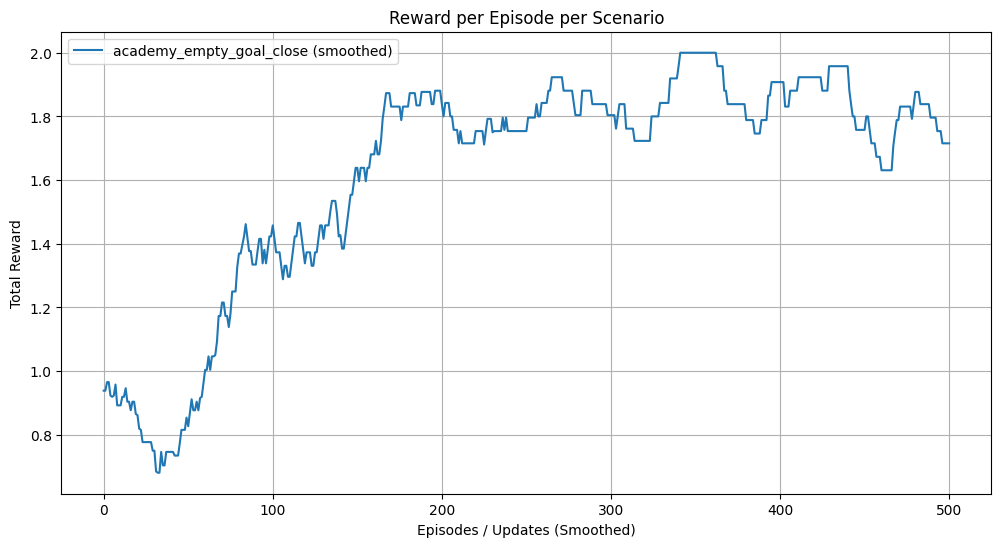

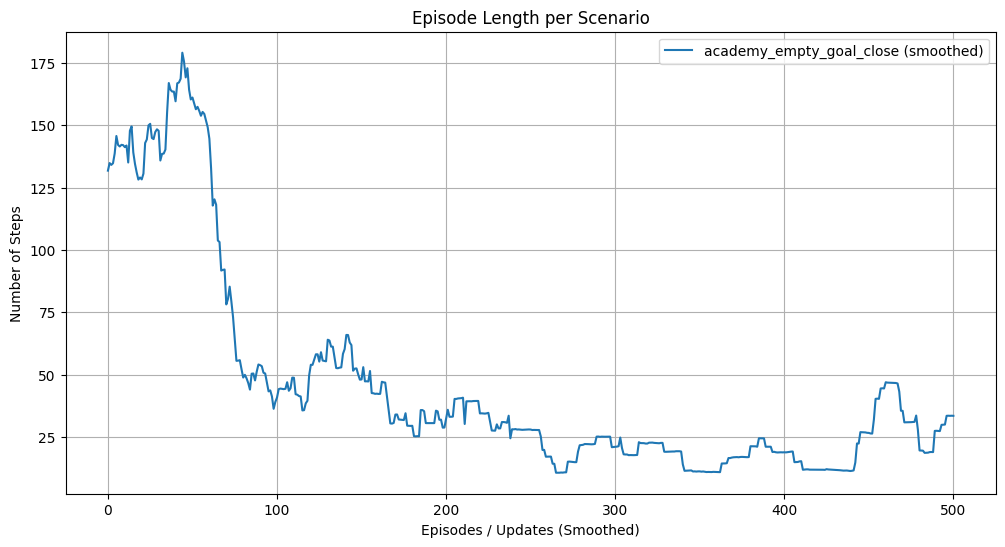

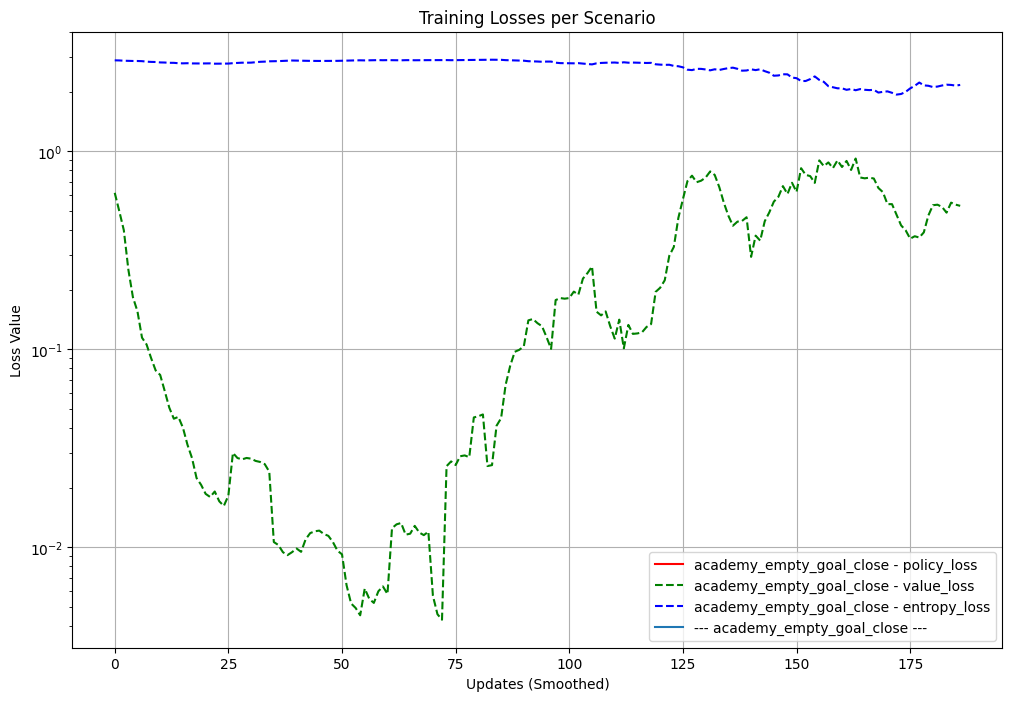

In [12]:
import matplotlib.pyplot as plt

def plot_metrics(metric_dict, title, ylabel):
    plt.figure(figsize=(12, 6))
    for scenario, values in metric_dict.items():
        if values: # Only plot if there's data
            # Smooth the curve for better visualization (e.g., moving average)
            window_size = max(1, len(values) // 20) # Adjust window size as needed
            smoothed_values = np.convolve(values, np.ones(window_size)/window_size, mode='valid')
            plt.plot(smoothed_values, label=f'{scenario} (smoothed)')
            # Optional: plot raw data too
            # plt.plot(values, label=f'{scenario} (raw)', alpha=0.3)

    plt.title(title)
    plt.xlabel("Episodes / Updates (Smoothed)") # Adjust label based on data collection frequency
    plt.ylabel(ylabel)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# --- Plot Rewards ---
plot_metrics(scenario_rewards, "Reward per Episode per Scenario", "Total Reward")

# --- Plot Episode Lengths ---
plot_metrics(scenario_episode_lengths, "Episode Length per Scenario", "Number of Steps")


# --- Plot Losses ---
def plot_losses(loss_dict, title):
    plt.figure(figsize=(12, 8))
    loss_types = ['policy_loss', 'value_loss', 'entropy_loss']
    colors = ['r', 'g', 'b']

    for scenario, losses in loss_dict.items():
        if any(losses[lt] for lt in loss_types): # Check if any loss data exists for the scenario
            for i, loss_type in enumerate(loss_types):
                if losses[loss_type]:
                     window_size = max(1, len(losses[loss_type]) // 20)
                     smoothed_values = np.convolve(losses[loss_type], np.ones(window_size)/window_size, mode='valid')
                     plt.plot(smoothed_values, label=f'{scenario} - {loss_type}', color=colors[i], linestyle='--' if i > 0 else '-')
            plt.plot([], [], label=f'--- {scenario} ---') # Separator for legend

    plt.title(title)
    plt.xlabel("Updates (Smoothed)")
    plt.ylabel("Loss Value")
    plt.legend(loc='best')
    plt.grid(True)
    plt.yscale('log') # Log scale often helps visualize losses
    plt.show()

plot_losses(scenario_losses, "Training Losses per Scenario")